In [1]:
import pandas as pd 
import numpy as np 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score,  GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.feature_selection import SelectKBest

In [2]:
#read_csv into file
df = pd.read_csv('full_features.csv')

#Convert Date column into datetime
df['Date'] = pd.to_datetime(df['Date'])

#Convert Date to year, month, day columns 

df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df = df.drop(['Date'], axis=1)

#One-hot-encode color column
color_dummies = pd.get_dummies(df['color'], prefix='color')
# Concatenate the one hot encoded columns to the original dataframe
df = pd.concat([df, color_dummies], axis=1)
# Drop the original color column
df.drop(['color'], axis=1, inplace=True)

#One-hot-encode variety_desc column
variety_dummies = pd.get_dummies(df['variety_desc'])
# Concatenate the one hot encoded columns to the original dataframe
df = pd.concat([df, variety_dummies], axis=1)

#Convert all negative 'ages' to NANs 
df['age'] = df['age'].mask(df['age'] < 0, np.nan)


df

,ranch_no,ranch_sub,var_cd,variety_desc,var_boxes,prod_yr,grafted,acres,year_planted_grafted,yield,...,EXPERIMENTAL 80B-30+9,EXPERIMENTAL 95B-59+6,FLAME SEEDLESS,IVORY - SHEEGENE 21,RED GLOBE,SCARLET ROYAL,SUGRAONE,SWEET GLOBE,SWEET SCARLET,THOMPSON SEEDLESS
0,1,NaN,178,ARRA 15 - SWEETIES,3905,2015,True,36.00,2009,108.472222,...,0,0,0,0,0,0,0,0,0,0
1,14,NaN,16,ARRA 16,3038,2015,True,8.00,2017,379.750000,...,0,0,0,0,0,0,0,0,0,0
2,14,NaN,16,ARRA 16,3038,2015,True,18.00,2018,168.777778,...,0,0,0,0,0,0,0,0,0,0
3,29,NW,71,SUGRAONE,23119,2015,True,88.00,2006,262.715909,...,0,0,0,0,0,0,1,0,0,0
4,29,NE,13,FLAME SEEDLESS,45799,2015,True,37.40,2011,1224.572193,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3631,32,NE,96,AUTUMN KING,23204,2018,False,289.60,2010,80.124309,...,0,0,0,0,0,0,0,0,0,0
3632,32,NE,96,AUTUMN KING,23204,2018,False,572.40,2012,40.538085,...,0,0,0,0,0,0,0,0,0,0
3633,32,NW,755,ARRA 28 - ARRA PASSION PUNCH,667,2018,True,69.35,2017,9.617880,...,0,0,0,0,0,0,0,0,0,0
3634,33,W,90,EARLY SWEET,4155,2019,False,63.00,2009,65.952381,...,0,0,0,0,0,0,0,0,0,0


In [7]:
#Drop unneccessary columns and rows with NAN and infinity values
#Dataset includes var_boxes and acres 
full_features = df.drop(['ranch_sub', 'prod_yr', 'yield', 'variety_desc', 'ranch_no',  'var_cd', 'grafted', 'var_boxes', 'acres'], axis=1)
full_features = full_features.replace([np.inf, -np.inf], np.nan)
full_features =  full_features.dropna()


yield_class = full_features['yield_class']

#drop yield_class from dataset
full_features = full_features.drop(['yield_class'], axis = 1)

# Define the pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('clf', LinearSVC(C=0.1))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(full_features, yield_class, test_size=0.3, random_state=42)

# Train the classifier using the pipeline
pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = pipeline.predict(X_test)

# Evaluate model performance
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

        high       0.66      0.66      0.66       578
         low       0.54      0.54      0.54       432

    accuracy                           0.61      1010
   macro avg       0.60      0.60      0.60      1010
weighted avg       0.61      0.61      0.61      1010



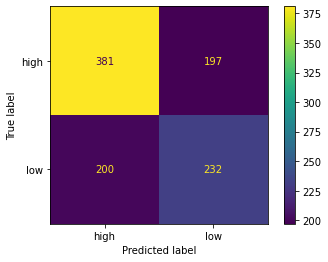

In [8]:
# Plot confusion matrix
plot_confusion_matrix(pipeline, X_test, y_test)
plt.show()

In [9]:
# Evaluate model using 5-fold cross-validation
scores = cross_val_score(pipeline, full_features, yield_class, cv=5)

# Print average performance across all folds
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Accuracy: 0.55 (+/- 0.05)
